Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (27.4 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/

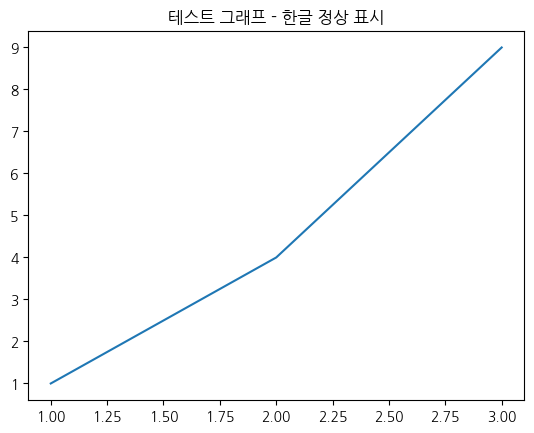

In [6]:
# @title
!apt-get -y install fonts-nanum
!fc-cache -fv
!rm -rf ~/.cache/matplotlib
import matplotlib.font_manager as fm
for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    if "Nanum" in font:
        print(font)


font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager
font_manager.fontManager.addfont(font_path)
font_name = font_manager.FontProperties(fname=font_path).get_name()  # 실제 패밀리명 얻기
mpl.rcParams["font.family"] = font_name
mpl.rcParams["axes.unicode_minus"] = False

print("사용 폰트:", font_name)

plt.plot([1,2,3],[1,4,9])
plt.title("테스트 그래프 - 한글 정상 표시")
plt.show()

월 샘플 수: 25 (처음: 2023-09-01, 끝: 2025-09-01)
학습 완료!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


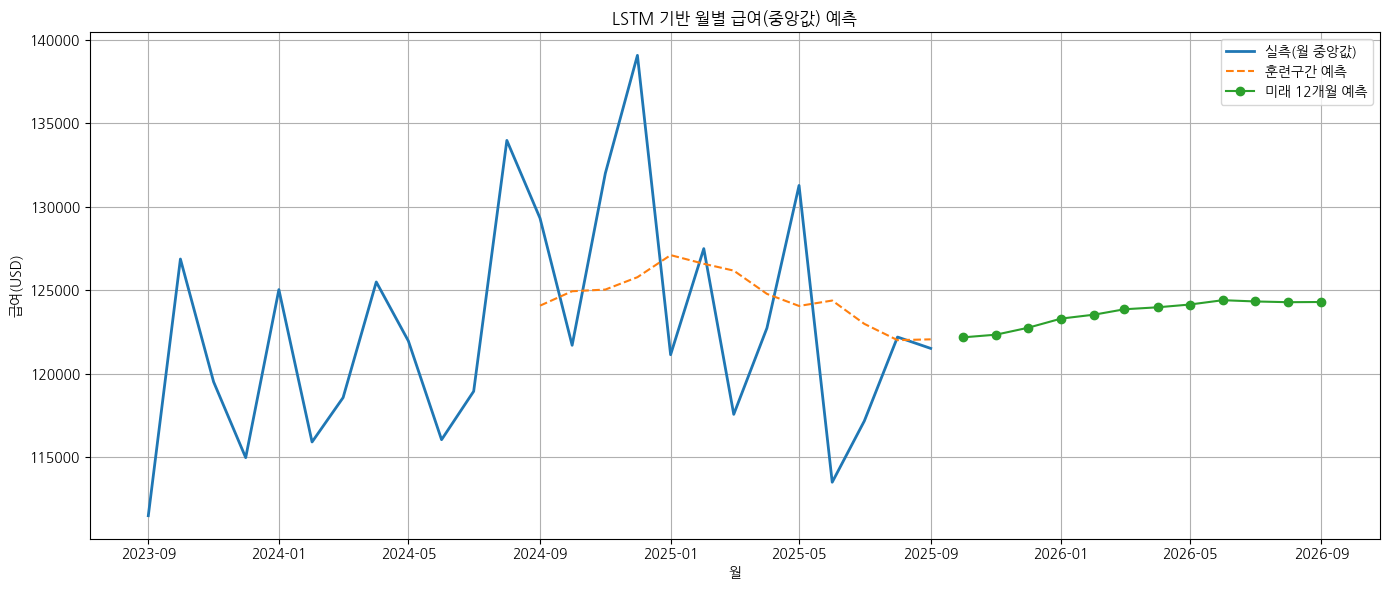

         date  salary_median_usd  is_forecast
0  2025-10-01      122174.734375         True
1  2025-11-01      122336.187500         True
2  2025-12-01      122751.468750         True
3  2026-01-01      123302.164062         True
4  2026-02-01      123538.812500         True
5  2026-03-01      123859.734375         True
6  2026-04-01      123977.617188         True
7  2026-05-01      124143.203125         True
8  2026-06-01      124404.328125         True
9  2026-07-01      124328.843750         True
10 2026-08-01      124284.062500         True
11 2026-09-01      124295.921875         True


In [7]:
# ===== 0) 기본 준비 =====
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# (선택) 경고 줄이기
import warnings
warnings.filterwarnings("ignore")

# ===== 1) 데이터 불러오기 =====
# 파일명은 실제 파일명으로 바꿔주세요.
df = pd.read_csv("ai_job_market.csv")

# ===== 2) 날짜 처리 =====
# posted_date -> datetime
df['posted_date'] = pd.to_datetime(df.get('posted_date'), errors='coerce')
df = df.dropna(subset=['posted_date'])  # 날짜 없는 행 제거

# ===== 3) 급여 정규화: salary_range_usd(문자열) -> 숫자 컬럼 만들기 =====
# 케이스 A: salary_range_usd가 "102770-117026" 같은 문자열 범위인 경우
def parse_salary_range_to_mid(x):
    """
    문자열 x가 '숫자-숫자' 형태면 중간값(평균)을 반환.
    숫자 하나만 있으면 그 숫자 반환.
    쉼표/공백/달러기호 등은 제거.
    숫자가 없거나 이상하면 np.nan
    """
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    # 통화기호/쉼표/문자 제거 (예: $120,000 -> 120000)
    s = re.sub(r'[^\d\-\s]', '', s)
    s = s.replace(' ', '')
    if not s:
        return np.nan

    if '-' in s:
        a, b = s.split('-', 1)
        if a.isdigit() and b.isdigit():
            a, b = int(a), int(b)
            return (a + b) / 2.0
        else:
            return np.nan
    else:
        # '123456' 처럼 단일 숫자
        if s.isdigit():
            return float(s)
        return np.nan

salary_mid_col = None

if 'salary_range_usd' in df.columns:
    df['salary_mid_usd'] = df['salary_range_usd'].apply(parse_salary_range_to_mid)
    salary_mid_col = 'salary_mid_usd'

# 케이스 B (대안): 이미 salary_min, salary_max가 숫자로 있는 경우 → 평균 사용
if salary_mid_col is None and {'salary_min','salary_max'}.issubset(df.columns):
    # 숫자 변환 시도
    for c in ['salary_min','salary_max']:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df['salary_mid_usd'] = (df['salary_min'] + df['salary_max']) / 2.0
    salary_mid_col = 'salary_mid_usd'

# 케이스 C (대안): salary_range_usd 대신 salary_range(다른 이름)만 있는 경우 → 이름 맞춰서 응용

# 마지막 안전장치: 사용 가능한 급여 수치 컬럼이 없으면 에러
if salary_mid_col is None:
    # 혹시 다른 컬럼명이 있다면 여기서 바꿔주세요 (예: 'salary_range' → parse)
    raise ValueError("급여 숫자 컬럼을 만들 수 없어요. salary_range_usd 또는 salary_min/max가 필요합니다.")

# 숫자 아닌 행 제거
df = df.dropna(subset=[salary_mid_col])

# ===== 4) 월별 중앙값(시계열)으로 집계 =====
# Period('M')로 월 그룹 → 타임스탬프로 되돌려 '월초 날짜'로 맞춤
ts = (
    df.groupby(df['posted_date'].dt.to_period('M'))[salary_mid_col]
      .median()
      .to_timestamp()  # PeriodIndex -> DatetimeIndex
      .sort_index()
)

# 데이터 양 확인
print(f"월 샘플 수: {len(ts)} (처음: {ts.index.min().date()}, 끝: {ts.index.max().date()})")

# 너무 짧으면 LSTM 학습이 어려울 수 있어요(보통 최소 24~36포인트 권장)
if len(ts) < 24:
    print("⚠️ 월 데이터가 24개 미만이면 LSTM 성능이 낮을 수 있습니다. Prophet 같은 단순 모델도 고려해보세요.")

# ===== 5) 정규화(스케일링) =====
values = ts.values.reshape(-1, 1)
scaler = MinMaxScaler()
values_scaled = scaler.fit_transform(values)

# ===== 6) 시퀀스 만들기 (윈도우=12개월, 필요시 바꿔도 됨) =====
def make_sequences(series2d, window=12):
    X, y = [], []
    for i in range(window, len(series2d)):
        X.append(series2d[i-window:i, 0])
        y.append(series2d[i, 0])
    X = np.array(X)
    y = np.array(y)
    # LSTM 입력: (samples, timesteps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

WINDOW = 12
X, y = make_sequences(values_scaled, window=WINDOW)

# ===== 7) LSTM 모델 =====
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(WINDOW, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(X, y, epochs=80, batch_size=8, verbose=0)
print("학습 완료!")

# ===== 8) 훈련 구간 내 예측(적합도 확인용) =====
pred_in_sample = model.predict(X)
pred_in_sample_inv = scaler.inverse_transform(pred_in_sample)

# 실측과 예측 길이를 맞추기 위해 앞의 WINDOW 개월은 비웁니다
real_aligned = ts.values[WINDOW:]

# ===== 9) 앞으로 12개월 예측 (recursive forecasting) =====
def forecast_recursive(last_window_scaled, steps=12):
    """
    last_window_scaled: shape (WINDOW, 1) 최근 WINDOW개의 스케일된 값
    steps: 예측할 개월 수
    """
    window = last_window_scaled.astype(np.float32).copy()
    preds_scaled = []
    for _ in range(steps):
        x_in = window.reshape((1, WINDOW, 1))
        p = model.predict(x_in, verbose=0)[0,0]
        preds_scaled.append(p)
        # 다음 윈도우 업데이트 (맨 앞값 제거 + 방금 예측 추가)
        window = np.vstack([window[1:], [[p]]])
    preds_scaled = np.array(preds_scaled).reshape(-1, 1)
    return preds_scaled

last_window_scaled = values_scaled[-WINDOW:]  # 최근 12개월
future_steps = 12
future_scaled = forecast_recursive(last_window_scaled, steps=future_steps)
future_pred = scaler.inverse_transform(future_scaled).flatten()

# 미래 날짜 인덱스 만들기 (월 단위로 12개월)
last_date = ts.index[-1]
future_index = pd.date_range(last_date + pd.offsets.MonthBegin(1), periods=future_steps, freq='MS')

# ===== 10) 시각화 =====
plt.figure(figsize=(14,6))
plt.plot(ts.index, ts.values, label='실측(월 중앙값)', linewidth=2)
plt.plot(ts.index[WINDOW:], pred_in_sample_inv.flatten(), label='훈련구간 예측', linestyle='--')

plt.plot(future_index, future_pred, label='미래 12개월 예측', marker='o')
plt.title("LSTM 기반 월별 급여(중앙값) 예측")
plt.xlabel("월")
plt.ylabel("급여(USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ===== 11) 결과 테이블 확인 (최근 6개월 + 예측 6개월) =====
result_df = pd.concat([
    pd.DataFrame({'date': ts.index, 'salary_median_usd': ts.values}),
    pd.DataFrame({'date': future_index, 'salary_median_usd': future_pred, 'is_forecast': True})
]).fillna({'is_forecast': False})

print(result_df.tail(12))